# Step by step guide for reconstruction of an image

Some introduction text about what to expect... Maybe some additional explanation where the data is located, or which packages are needed...

Import modules to load and process the data. Numpy handels data chrunching, h5py is responsible for file I/O

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os

Define the rawdata path and optional the desired acceleration

In [2]:
    path = 'rawdata_brain_radial_96proj_12ch.h5'
    acc = 1    

Read in data. The if/else for the heart is used to select the exact number of spokes as in the reference paper. Further we rotate and scale the loaded trajectory data.

In [3]:
    if not os.path.isfile(path):
        raise ValueError("Data file does not exist")

    name = os.path.normpath(path)
    h5_dataset = h5py.File(name, 'r')
    h5_dataset_rawdata_name = 'rawdata'
    h5_dataset_trajectory_name = 'trajectory'

    if "heart" in name:
        if acc == 2:
            trajectory = h5_dataset.get(h5_dataset_trajectory_name)[:, :, :33]
            rawdata = h5_dataset.get(h5_dataset_rawdata_name)[:, :, :33, :]
        elif acc == 3:
            trajectory = h5_dataset.get(h5_dataset_trajectory_name)[:, :, :22]
            rawdata = h5_dataset.get(h5_dataset_rawdata_name)[:, :, :22, :]
        elif acc == 4:
            trajectory = h5_dataset.get(h5_dataset_trajectory_name)[:, :, :11]
            rawdata = h5_dataset.get(h5_dataset_rawdata_name)[:, :, :11, :]
        else:
            trajectory = h5_dataset.get(h5_dataset_trajectory_name)[...]
            rawdata = h5_dataset.get(h5_dataset_rawdata_name)[...]
    else:
        trajectory = h5_dataset.get(h5_dataset_trajectory_name)[:, :, ::acc]
        rawdata = h5_dataset.get(h5_dataset_rawdata_name)[:, :, ::acc, :]

    # Squeeze dummy dimension and transpose to C-style ordering.
    rawdata = np.squeeze(rawdata.T)

    # Norm Trajectory to the range of (-1/2)/(1/2)
    max_trajectory = 2 * np.max(trajectory[0])
    trajectory = np.require((trajectory[0]/max_trajectory + 1j * trajectory[1]/max_trajectory).T, requirements='C')

    # Close file after everything was read
    h5_dataset.close()

To give you an idea what kind of data we just loaded, here a visual representation of the trajectory.

Text(0.5, 1.0, 'imaginary part')

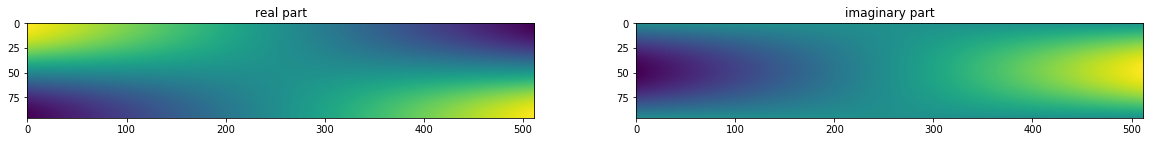

In [4]:
    # Comment: this is just a simple method.. could think of something better
    fig, ax = plt.subplots(1, 2, figsize=(20,20))
    ax[0].imshow(np.real(trajectory))
    ax[0].set_title('real part')
    ax[1].imshow(np.imag(trajectory))
    ax[1].set_title('imaginary part')

The raw data looks like this... (could be using Domain Coloring to properly display this)

In [8]:
    np.fft.fftn(rawdata)

array([[[ 1.37559997e+00-1.86228051e+00j,
         -1.38551999e+00+1.85574414e+00j,
          1.39381684e+00-1.84443786e+00j, ...,
         -1.35403819e+00+1.88305341e+00j,
          1.35981033e+00-1.87428646e+00j,
         -1.36527861e+00+1.86506911e+00j],
        [-8.80306354e-02+2.51281288e-01j,
          1.02055699e-01-2.54314296e-01j,
         -1.08739556e-01+2.47394488e-01j, ...,
          6.18710389e-02-2.64014663e-01j,
         -6.84090788e-02+2.57213427e-01j,
          8.11932280e-02-2.54864645e-01j],
        [ 4.12359945e-02-9.70052990e-02j,
         -4.20265853e-02+9.81108256e-02j,
          3.76502338e-02-9.50424312e-02j, ...,
         -4.18713759e-02+9.36132995e-02j,
          4.07092929e-02-9.12294454e-02j,
         -4.00792099e-02+9.36429368e-02j],
        ...,
        [ 3.01768715e-02+7.63312320e-02j,
         -3.49146335e-02-7.80148103e-02j,
          3.89372610e-02+8.20203816e-02j, ...,
         -1.72969364e-02-7.23084967e-02j,
          1.95821537e-02+7.10203150e-02j

Setup dict to hold essential data properties. The over grid factor (ogf) defines the amount of oversampling of the non Cartesian k-space gridded on an Cartesian grid. The brain data is oversampled by 1.706, the heart by a factor of 1+1/3.

In [25]:
    # Create empty dict
    par = {}
    nCh, nSpokes, nFE = rawdata.shape

    par["ogf"] = 1.706
    dimX, dimY = [int(nFE/par["ogf"]), int(nFE/par["ogf"])]
    
    par["NC"] = nCh
    par["dimY"] = dimY
    par["dimX"] = dimX
    par["nFE"] = nFE
    par["Nproj"] = nSpokes

Calculate density compensation function (dcf). Currently assumes golden angle radial trajectories

In [26]:
    if len(np.shape(trajectory)) == 2:
        nspokes, N = np.shape(trajectory)
    elif len(np.shape(trajectory)) == 3:
        NScan, nspokes, N = np.shape(trajectory)
    else:
        raise ValueError("Passed trajectory has the wrong "
                         "number of dumensions.")

    dcf = np.abs(np.linspace(-N/2, N/2, N))/(N/2)  # ramp from 1...1
    dcf = np.repeat(dcf, nspokes, 0)
    dcf /= np.min(dcf)
    dcf *= (np.pi / 4) / nspokes
    dcf = np.reshape(dcf, (N, nspokes)).T

Apply square root of dcf to data to ensure adjointness of nuFFT operations

In [27]:
    dcf = np.sqrt(dcf)
    rawdata /= dcf

Perform the Iterative Reconstruction

### TODO what I will do here is a step by step guide of the classes that you have written down.. together with some insightful plots probably
#

RECON CODE GOES HERE

Save the results

In [28]:
    outdir = ""
    if "heart" in path:
        outdir += "/heart"
    elif "brain" in path:
        outdir += "/brain"
    if not os.path.exists('./output'):
        os.makedirs('output')
    if not os.path.exists('./output' + outdir):
        os.makedirs("./output" + outdir)
    cwd = os.getcwd()
    os.chdir("./output" + outdir)
    f = h5py.File("CG_reco_inscale_" +
                  "_acc_" + str(acc), "w")
    f.create_dataset("CG_reco", result.shape,
                     dtype=DTYPE, data=result)
    f.flush()
    f.close()
    os.chdir(cwd)


NameError: name 'result' is not defined